Author: Qiu Yang

CNN-RNN-CNN

**Settings used for current result:**

toy_dataset, 20000 training , 4000 testing, [X, Y, 0/1], added 0s, model_2, 87%

In [0]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
import time
import numpy as np
import random
import pickle
import os.path as path
import matplotlib.pyplot as plt
from matplotlib.path import Path


In [2]:
device= torch.device("cuda")
#device= torch.device("cpu")
print(device)
torch.cuda.is_available()

cuda


True

# Datasets

**unpack dataset**

In [3]:
data_path  = ''
with open(path.join(data_path,'data_X'),'rb') as f:
    X=pickle.load(f)
    
with open(path.join(data_path,'data_Y'),'rb') as f:
    Y=pickle.load(f)
    
len_train_X=int(len(X)*0.8)

train_data_raw=np.array(X[:len_train_X])
train_label=np.array(Y[:len_train_X])
test_data_raw=np.array(X[len_train_X:])
test_label=np.array(Y[len_train_X:])


print(len(train_data_raw),len(train_label))

print(len(test_data_raw),len(test_label))


35685 35685
8922 8922


In [4]:
#check classes
a = set(train_label)
print(a)

{'penguin', 'calendar', 'teddy-bear', 'snowman', 'blackberry'}


**A random sample**

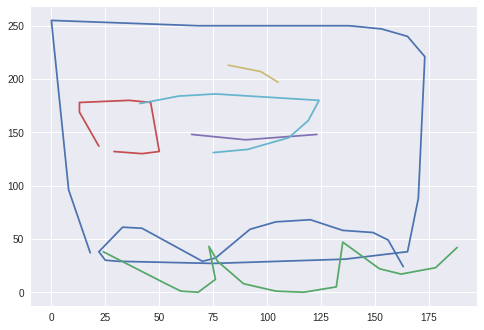

In [5]:
sketch = random.choice(train_data_raw)
for i in range(len(sketch)):
    plt.plot(sketch[i][0][:], sketch[i][1][:])
    
plt.show()

**Sub-sampling(for faster run) and reformat**

In [6]:
#sub sample for experiment due to memory limit
train_size=20000
test_size=4000

train_sample = train_data_raw[0:train_size]
train_label_sample = train_label[0:train_size]

test_sample = test_data_raw[0:test_size]
test_label_sample = test_label[0:test_size]
#train_sample = random.sample(list(train_data_raw),train_size)
#test_sample = random.sample(list(test_data_raw),test_size)
print(len(train_sample))
no_point = 0;


def get_max_len(sub_sample):
    max_stroke_length = 0
    max_point_length = 0
    for i in range(len(sub_sample)): #each image
        if len(sub_sample[i])> max_stroke_length: 
            max_stroke_length = len(sub_sample[i])
        for j in range(len(sub_sample[i])): #each strokes
            if len(sub_sample[i][j][0])> max_point_length:
                max_point_length = len(sub_sample[i][j][0])
    return max_stroke_length,max_point_length
                
max_stroke_len,max_point_len = get_max_len(train_sample)    
print (max_stroke_len,max_point_len)
    
# no 0
def process_data(sub_sample, append):
    stroke_data = []
    point_data = []
    for i in range(len(sub_sample)): #image
        for j in range(len(sub_sample[i])): #strokes
            for k in range(len(sub_sample[i][j][0])): #points
                if append:
                    if k == len(sub_sample[i][j][0])-1:
                        temp2 = [sub_sample[i][j][0][k],sub_sample[i][j][1][k],1]
                    else:
                        temp2 = [sub_sample[i][j][0][k],sub_sample[i][j][1][k],0]
                    point_data.append(temp2)
                else:
                    temp = [sub_sample[i][j][0][k],sub_sample[i][j][1][k]]
                    point_data.append(temp)
        stroke_data.append(point_data)
        point_data = []
            
    return stroke_data

# augment with 0
def unpack(x,max_strock,max_len):
    x_new=torch.zeros(torch.Size([x.shape[0],max_strock,3,max_len]))
    for i,item in enumerate(x):
        for j,strock in enumerate(item):
            strock=torch.Tensor(strock)
            x_new[i,j,0,:len(strock[0])]=strock[0]
            x_new[i,j,1,:len(strock[0])]=strock[1]
            x_new[i,j,2,:len(strock[0])]=0
            x_new[i,j,2,len(strock[0])-1]=1
    return x_new

# no 0
train_data = process_data(train_sample, 1)
test_data = process_data(test_sample, 1)

print (len(train_data))
print (len(test_data))

# with 0
train_data_amend = unpack(train_sample,max_stroke_len,max_point_len)
test_data_amend = unpack(test_sample,max_stroke_len,max_point_len)

print (train_data_amend.shape)
print (test_data_amend.shape)

print(train_data_raw[0])
print(train_data[0])


20000
61 556
20000
4000
torch.Size([20000, 61, 3, 556])
torch.Size([4000, 61, 3, 556])
[[[30, 24, 23, 25, 33, 68, 131, 151, 160, 163, 164, 150, 128, 79, 49, 37], [90, 81, 41, 34, 26, 12, 0, 17, 32, 48, 99, 114, 118, 117, 103, 85]], [[58, 43, 21, 10, 1, 0, 14, 27, 158, 166, 193, 193, 189, 183, 173, 133, 62, 56, 50], [243, 241, 234, 225, 210, 168, 145, 140, 132, 135, 180, 220, 233, 240, 247, 255, 251, 250, 241]]]
[[30, 90, 0], [24, 81, 0], [23, 41, 0], [25, 34, 0], [33, 26, 0], [68, 12, 0], [131, 0, 0], [151, 17, 0], [160, 32, 0], [163, 48, 0], [164, 99, 0], [150, 114, 0], [128, 118, 0], [79, 117, 0], [49, 103, 0], [37, 85, 1], [58, 243, 0], [43, 241, 0], [21, 234, 0], [10, 225, 0], [1, 210, 0], [0, 168, 0], [14, 145, 0], [27, 140, 0], [158, 132, 0], [166, 135, 0], [193, 180, 0], [193, 220, 0], [189, 233, 0], [183, 240, 0], [173, 247, 0], [133, 255, 0], [62, 251, 0], [56, 250, 0], [50, 241, 1]]


In [7]:
#string to int label
label_set = set(train_label_sample)
label_list = list(label_set)
train_label_tensor = []
for i in range(len(train_label_sample)):
    train_label_tensor.append(label_list.index(train_label_sample[i]))
test_label_set = set(test_label)
test_label_list = list(test_label_set)
test_label_tensor = []
for i in range(len(test_label_sample)):
    test_label_tensor.append(test_label_list.index(test_label_sample[i]))  
print (len(train_label_tensor),train_label_tensor[0],len(test_label_tensor))
print(set(train_label_tensor),set(test_label_tensor))

20000 3 4000
{0, 1, 2, 3, 4} {0, 1, 2, 3, 4}


# Other data format (not used)

In [45]:
#append labels to match no.points
total_train_label = []
total_test_label = []

for i in range(len(train_data)):
    for j in range(len(train_data[i])):
        total_train_label.append(train_label_tensor[i])
        
for i in range(len(test_data)):
    for j in range(len(test_data[i])):
        total_test_label.append(test_label_tensor[i])
        
print(len(total_train_label),total_train_label[0])
print(len(total_test_label))

637360 3
130487


In [0]:
#a list of all points
train_data_points =[]
test_data_points = []

for i in range(len(train_data)):
    train_data_points.extend(train_data[i])
    
for i in range(len(test_data)):
    test_data_points.extend(test_data[i])

print (len(train_data_points),train_data_points[0])
print (len(test_data_points))

# define manually according to factorization of the total no.points
point_bs = 19
point_len = 16777


train_data_points = torch.LongTensor(train_data_points)
total_train_label_tensor = torch.LongTensor(total_train_label)


# lstm batch_first = true
train_data_shaped = torch.zeros(point_bs,point_len,3)
train_label_shaped = torch.zeros(point_bs,point_len)

for i in range(point_bs):
    train_data_shaped[i,:,:] = train_data_points[i*point_len:(i+1)*point_len]
    train_label_shaped[i,:] = total_train_label_tensor[i*point_len:(i+1)*point_len]
    
#train_data_shaped = torch.transpose(train_data_shaped,0,1)
print(train_data_shaped.shape,train_label_shaped.shape,train_data_shaped[:,0,:])

# Model

**Model_2: one score for each stroke**

In [23]:
#determine/adjust parameters
m = nn.Conv1d(3, 6, 3,padding = 1)
m2 = nn.Conv1d(1,3,3, padding = 1)
l = nn.LSTM(3336, 40)
p = nn.MaxPool2d(2,2)
input = torch.randn(61, 3, 556)
output = m(input)
print('c1',output.shape)
output = F.relu(output)
output = output.view(61,1,-1)
print('v1',output.shape)
output,_ = l(output)
print('l',output.shape)
output = m2(output)
print('c2',output.shape)
output = p(output)
print('mp',output.shape)
output = output.view(-1,1220)
print('v2',output.shape)

c1 torch.Size([61, 6, 556])
v1 torch.Size([61, 1, 3336])
l torch.Size([61, 1, 40])
c2 torch.Size([61, 3, 40])
mp torch.Size([61, 1, 20])
v2 torch.Size([1, 1220])


In [0]:
class lstm_cnn (nn.Module):

    def __init__(self):
        super(lstm_cnn, self).__init__()
        
        self.conv1 = nn.Conv1d(3,6,3,padding = 1) #2 output channel for 1 input channel
        self.lstm = nn.LSTM(3336, 40) # input_size = No. points in 1 stroke.
        self.conv2 = nn.Conv1d(1,3,3, padding = 1) #3 channels for 1 h_seq
        self.pool = nn.MaxPool2d(2, 2)
        self.linear = nn.Linear(1220  , 100)
        self.output = nn.Linear(100, 5)

        
    def forward(self, input_data, h_init, c_init ):
        temp = self.conv1(input_data)
        #print(temp.shape)
        temp = F.relu(temp)
        #print(temp.shape)
        temp = temp.view(61,1,-1)
        #print(temp.shape)
        h_seq , (h_final,c_final)  =   self.lstm( temp , (h_init,c_init) )
        temp = self.conv2(h_seq)
        temp = F.relu(temp)
        temp = self.pool(temp)
        temp = temp.view(-1,1220)
        temp = self.linear(temp)
        temp = F.relu(temp) 
        score = self.output(temp)
        
        return score

**Build the net**

In [27]:
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('There are {} ({:.2f} million) parameters in this neural network'.format(
        nb_param, nb_param/1e6)
         )

net = lstm_cnn()

print(net)

display_num_param(net)

lstm_cnn(
  (conv1): Conv1d(3, 6, kernel_size=(3,), stride=(1,), padding=(1,))
  (lstm): LSTM(3336, 40)
  (conv2): Conv1d(1, 3, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=1220, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=5, bias=True)
)
There are 663157 (0.66 million) parameters in this neural network


In [20]:
net = net.to(device)

net.linear.weight.data.uniform_(-0.1, 0.1)
#net.linear1.weight.data.uniform_(-0.1, 0.1)
#net.linear2.weight.data.uniform_(-0.1, 0.1)
net.output.weight.data.uniform_(-0.1, 0.1)

tensor([[ 0.0406,  0.0544, -0.0308,  0.0666,  0.0921, -0.0778, -0.0989, -0.0212,
          0.0200,  0.0492, -0.0372,  0.0864, -0.0569,  0.0007,  0.0205,  0.0601,
          0.0789,  0.0890,  0.0390,  0.0603, -0.0874,  0.0478,  0.0789, -0.0727,
          0.0524, -0.0302, -0.0386,  0.0174,  0.0748,  0.0889, -0.0292,  0.0594,
         -0.0185,  0.0675,  0.0096,  0.0220,  0.0812,  0.0713,  0.0132, -0.0182,
          0.0837,  0.0235,  0.0161,  0.0600, -0.0060,  0.0281,  0.0144, -0.0933,
          0.0595,  0.0112, -0.0103,  0.0397, -0.0790, -0.0032,  0.0673, -0.0106,
          0.0427,  0.0806,  0.0092, -0.0520,  0.0977, -0.0670, -0.0366, -0.0299,
          0.0236, -0.0315,  0.0594,  0.0473, -0.0854, -0.0349, -0.0826, -0.0476,
         -0.0284, -0.0172,  0.0854,  0.0061, -0.0284, -0.0776, -0.0599,  0.0644,
          0.0157,  0.0500, -0.0403,  0.0934, -0.0577, -0.0025, -0.0730,  0.0388,
         -0.0348,  0.0723, -0.0607, -0.0849, -0.0812,  0.0964,  0.0006,  0.0147,
         -0.0910, -0.0965,  

**Loss function**

In [0]:
criterion = nn.CrossEntropyLoss()


# Training and evaluation

DONE:

reduced learning capacity

reduced learning rate

doubled training and testing dataset

TODO:

keep tuning 

wasserstein for loss

weighted cross-entropy:
loss = nn.CrossEntropyLoss(weight = weight.type(dtypeFloat))(y,y_target)

train loss okay, test loss fluctuating:  overfitting? try dropout/L1 L2 regularization on weights or activations

 **Training by image**

In [0]:
def eval_on_test_set():

    running_loss=0
    num_batches=0    
    
    correct = 0
    
    correct_0 = 0
    correct_1 = 0
    correct_2 = 0
    correct_3 = 0
    correct_4 = 0
    
    h = torch.zeros(1, 1, 40)
    c = torch.zeros(1, 1, 40)
   
    h=h.to(device)
    c=c.to(device)
       
    for count in range( len(test_data_amend)) :
               
        minibatch_data =  test_data_amend[ count  ]
        minibatch_label = test_label_tensor[ count  ]
        minibatch_label = torch.LongTensor([minibatch_label]).view(-1)
        
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
                                  
        scores = net( minibatch_data, h , c)
        
        loss = criterion(  scores ,  minibatch_label )    
        
        h=h.detach()
        c=c.detach()
            
        running_loss += loss.item()
        num_batches += 1        

        _, predicted = torch.max(scores,1)
        #print(predicted,scores,minibatch_label)
        #total += minibatch_label.size(0)
        if predicted == minibatch_label:
            correct+=1
            if predicted == 0:
                correct_0+=1
            elif predicted == 1:
                correct_1+=1
            elif predicted == 2:
                correct_2+=1                
            elif predicted == 3:
                correct_3+=1        
            elif predicted == 4:
                correct_4+=1                    
        #print([predicted, minibatch_label[0], minibatch_label])
    
    total_loss = running_loss/num_batches 
    print('test: exp(loss) = ', math.exp(total_loss)  )
    print ('correct', correct, 'correcr_0', correct_0,'correct_1',correct_1,'correcr_2', correct_2,'correct_3',correct_3,'correct_4',correct_4)
    print ('Test accuracy:{}%'.format(100 * correct / len(test_data_amend)))

In [22]:
start=time.time()
lr = 0.001 #default for adam

for epoch in range(100):
 
    if epoch > 5:
        lr = lr / 2
    
    if lr < 0.0001:
        lr = 0.0001
        
    optimizer=torch.optim.Adam( net.parameters(),lr = lr)
        
    running_loss=0
    num_batches=0    
       
    h = torch.zeros( 1, 1, 40)
    c = torch.zeros( 1, 1, 40)
    
    h=h.to(device)
    c=c.to(device)
    
    for count in range( len(train_data_amend)):
        
        optimizer.zero_grad()
        
        minibatch_data = train_data_amend[ count]
        minibatch_label = train_label_tensor[count]
        minibatch_label = torch.LongTensor([minibatch_label]).view(-1)
        #print (minibatch_data.shape)
        #print (minibatch_label)

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        h=h.detach()
        c=c.detach()
        h=h.requires_grad_()
        c=c.requires_grad_()
                       
        # forward the minibatch through the net        
        scores = net( minibatch_data, h , c )
        
        # Compute the average of the losses of the data points in this huge batch
        loss = criterion(  scores ,  minibatch_label )
        
        # backward pass to compute dL/dR, dL/dV and dL/dW
        loss.backward()

        optimizer.step()
                    
        # update the running loss  
        running_loss += loss.item()
        num_batches += 1
                
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    elapsed = time.time()-start
    
    print('')
    print('epoch=',epoch, '\t time=', elapsed, '\t exp(loss)=',  math.exp(total_loss))
    
    eval_on_test_set()



epoch= 0 	 time= 371.83787536621094 	 exp(loss)= 2.2207724025692888
test: exp(loss) =  1.852122313788179
correct 3135 correcr_0 576 correct_1 886 correcr_2 485 correct_3 915 correct_4 273
Test accuracy:78.375%

epoch= 1 	 time= 771.8687386512756 	 exp(loss)= 1.8060085159950163
test: exp(loss) =  1.689108645482406
correct 3280 correcr_0 622 correct_1 908 correcr_2 526 correct_3 937 correct_4 287
Test accuracy:82.0%

epoch= 2 	 time= 1225.363130569458 	 exp(loss)= 1.7392011626571986
test: exp(loss) =  1.7134471482558267
correct 3250 correcr_0 655 correct_1 898 correcr_2 505 correct_3 926 correct_4 266
Test accuracy:81.25%

epoch= 3 	 time= 1651.7655174732208 	 exp(loss)= 1.6953867877652469
test: exp(loss) =  1.6634108130258214
correct 3291 correcr_0 664 correct_1 890 correcr_2 526 correct_3 921 correct_4 290
Test accuracy:82.275%

epoch= 4 	 time= 2092.6755650043488 	 exp(loss)= 1.6652030207688964
test: exp(loss) =  1.6392482907393584
correct 3323 correcr_0 658 correct_1 921 correcr_2 5

KeyboardInterrupt: ignored